# Analysis of generated data

In [1]:
from config import DATA

import os, sys, time, pickle, warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from structure.model import ConvNet

from meg.loss import PatternMatchingLoss
from meg.meg import MaximumEntropyGenerator
from meg.model import Energy, Entropy, Generator

from pgm.layers import GaussianLayer, OneHotLayer, DReLULayer
from pgm.edge import Edge
from pgm.model import MRF
from pgm.data import SequenceStructureData, SequenceData

ROOT = "/home/malbranke/"
sys.path.append(f"{ROOT}")

device = torch.device('cpu')
warnings.filterwarnings("ignore")
torch.cuda.is_available()

AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
DATASET = "PF00397"
# DATASET = "PF07736"
q = 21
N = 60

In [2]:
all_files = [f[:-3] for f in os.listdir(f"{DATA}/{DATASET}/gen_data") if f[-3:] == ".pt"]
all_files

['ind_rejection_sampling_T_10000',
 'rbm_rejection_sampling_T_100',
 'rbm_rejection_sampling_T_0.5',
 'ind_rejection_sampling_T_1',
 'rbm_rejection_sampling_T_10',
 'rbm_rejection_sampling_T_20',
 'ind_rejection_sampling_T_3',
 'ind_rejection_sampling_T_0.5',
 'rbm_rejection_sampling_T_60',
 'rbm_rejection_sampling_T_10000',
 'rbm_rejection_sampling_T_30',
 'ind_rejection_sampling_T_30',
 'natural',
 'ind_rejection_sampling_T_60',
 'rbm_rejection_sampling_T_5',
 'ind_rejection_sampling_T_5',
 'ind_rejection_sampling_T_10',
 'rbm_rejection_sampling_T_3',
 'ind_rejection_sampling_T_20',
 'ind_rejection_sampling_T_100',
 'rbm_rejection_sampling_T_1']

In [3]:
all_files = ['natural',
#              'rbm_seq',
#  'rbm_seq_ss',
 'ind_rejection_sampling_T_1',
 'ind_rejection_sampling_T_30',
 'ind_rejection_sampling_T_10000',
 'rbm_rejection_sampling_T_1',
 'rbm_rejection_sampling_T_30',
 'rbm_rejection_sampling_T_10000',
#  'rbm_seq_ss_rejection_sampling_T_3',
#  'rbm_seq_ss_rejection_sampling_T_30',
#  'rbm_seq_ss_rejection_sampling_T_10000',

#  'meg_without_matching', 'meg_without_matching_better',

#  'meg_with_matching', 'meg_with_matching_better',
 ]


## RBM Energy

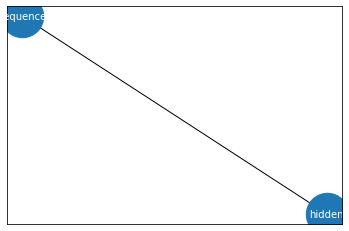

15.39091682434082

In [13]:
train_dataset = SequenceData(f"{DATA}/{DATASET}", dataset="train")

pots = np.zeros((train_dataset.raw_sequences.shape[1], train_dataset.raw_sequences.shape[2]))
for w, v in zip(train_dataset.weights,train_dataset.raw_sequences):
    pots += w*v
pots /= np.sum(train_dataset.weights)
pots = pots.T
pots = torch.FloatTensor((pots.T-np.mean(pots, 1)).T).reshape(-1).to(device)

visible_layers = ["sequence"]
hidden_layers = ["hidden"]

v = OneHotLayer(pots, N=N, q=q, name="sequence")
h = GaussianLayer(N=200, name="hidden")

E = [(v.name, h.name)]

model1 = MRF(layers={v.name: v,
                    h.name: h},
            edges=E)

for visible in visible_layers:
    edge = model1.get_edge(visible, "hidden")
    
model1.load(f"{DATA}/{DATASET}/weights/seq-reg-200_630.h5")
model1.ais()

In [14]:
def E(x):
    d =  {"sequence":x}
    seq = -(model1.integrate_likelihood(d, "hidden")/N - model1.Z)
    print(seq)
    return seq

In [15]:
Es = []
for filename in all_files:
    x = torch.load(f"{DATA}/{DATASET}/gen_data/{filename}.pt")
    Es.append(E(x.float()).detach())

tensor([0.6198, 0.5296, 0.7841,  ..., 0.4538, 0.4801, 1.2749],
       grad_fn=<NegBackward>)
tensor([1.5779, 1.3721, 1.3696,  ..., 1.3933, 1.4179, 1.4520],
       grad_fn=<NegBackward>)
tensor([1.4357, 1.8752, 1.6347,  ..., 1.9500, 2.0736, 1.5524],
       grad_fn=<NegBackward>)
tensor([1.7933, 1.9014, 1.6819,  ..., 1.7476, 1.8453, 1.6470],
       grad_fn=<NegBackward>)
tensor([0.7984, 0.6281, 0.8285,  ..., 0.7693, 0.9872, 0.4641],
       grad_fn=<NegBackward>)
tensor([0.6749, 0.4882, 0.6879,  ..., 1.2037, 0.4531, 0.6604],
       grad_fn=<NegBackward>)
tensor([0.5412, 0.4896, 0.7391,  ..., 0.5959, 0.6667, 0.5822],
       grad_fn=<NegBackward>)


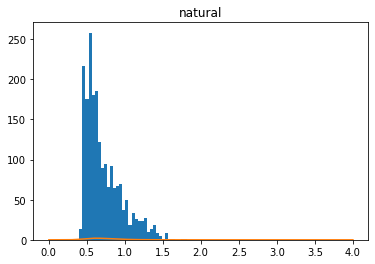

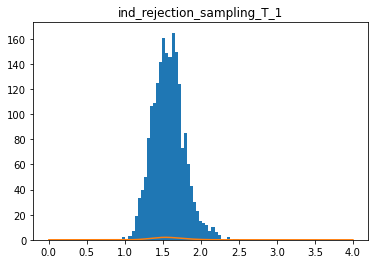

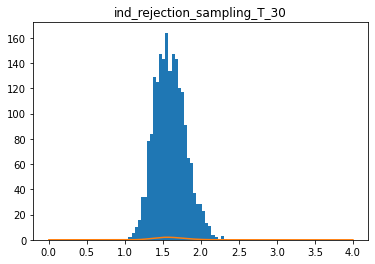

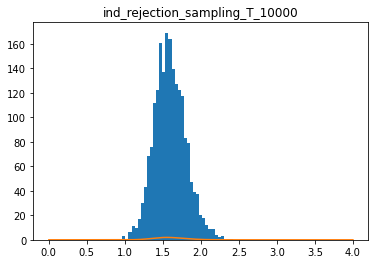

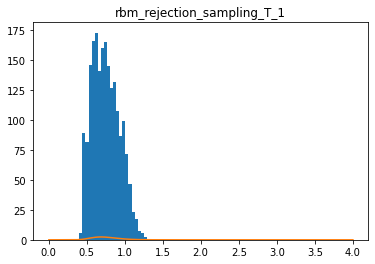

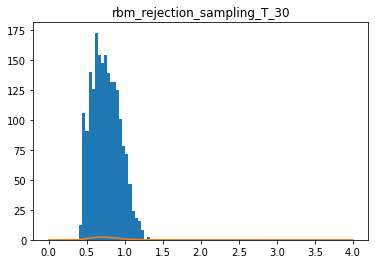

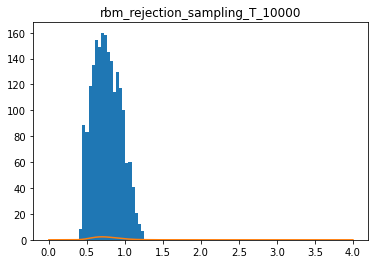

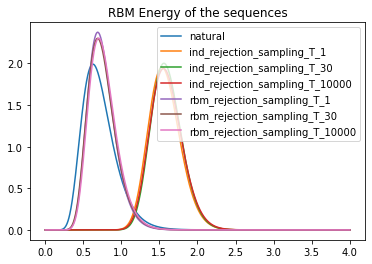

In [16]:
m, M = 0, 4
x = np.linspace(m, M, 1000)
x_hist = np.linspace(m, M, 100)

pdfs= []
for i, (m_,f) in enumerate(zip(Es,all_files)):
    mu, std = np.log(np.array(m_)).mean(0), np.log(np.array(m_)).std(0)
    pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * std**2)) / (x * std * np.sqrt(2 * np.pi)))
    pdfs.append(pdf)
    plt.hist(np.array(m_), bins=x_hist)
    plt.plot(x,pdf)
    plt.title(f)
    plt.show()

for pdf in pdfs:
    plt.plot(x, pdf)

plt.legend(all_files)
plt.title("RBM Energy of the sequences")

plt.show()

Text(0.5, 1.0, 'RBM Energy of the sequences')

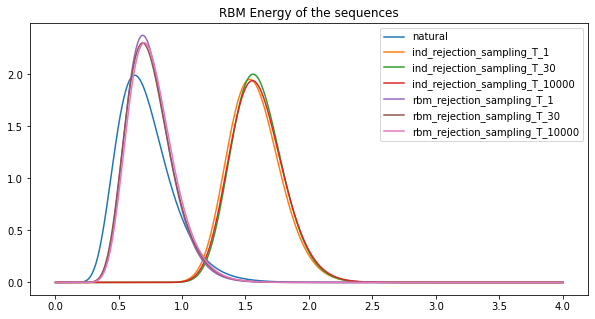

In [17]:
plt.figure(figsize = (10,5))

for pdf in pdfs:
    plt.plot(x, pdf)

plt.legend(all_files)
plt.savefig('reports/img/sampling_edca.png')
plt.title("RBM Energy of the sequences")

## Secondary structure

In [18]:
qx, qs = 40, 3
model_ss3 = HmmConvNet(qx, qs)
model_ss3 = model_ss3.to(device)
model_ss3.load_state_dict(torch.load(f"{DATA}/secondary_structure/model_40feats.h5"))
model_ss3.eval()

ss_hmm = torch.tensor(pickle.load(open(f"{DATA}/{DATASET}/ss_profile.pkl","rb")).T)
n_patterns, c_patterns, _ =  pickle.load(open(f"{DATA}/{DATASET}/patterns.pkl","rb"))
regexes = []
for x in n_patterns:
    if len(x):
        regexes.append([(i,None,None) for i in x])
Q,T,pi = pickle.load(open(f"{DATA}/secondary_structure/statistics.pkl", "rb"))
T = torch.zeros(*T.shape)
inf = float("Inf")
x, y, z, t = np.where(Q > -inf)
Q[x,y,z,t] = 0

HMM = torch.load(f"{DATA}/{DATASET}/hmm.pt")

matcher = PatternMatchingLoss(model_ss3, 
                              pattern = regexes[0], 
                              Q = Q, seq_hmm = HMM, ss_hmm = ss_hmm, size = 200)


In [12]:
matcher.do_match = False

In [19]:
matching = []
for filename in all_files:
    x = torch.load(f"{DATA}/{DATASET}/gen_data/{filename}.pt")
    matching.append(matcher(x))

In [20]:
matching

[tensor([-0.2153, -0.2316, -0.2492,  ..., -0.2207, -0.2090, -0.1820],
        grad_fn=<DivBackward0>),
 tensor([-0.2363, -0.2134, -0.1927,  ..., -0.2709, -0.2160, -0.1678],
        grad_fn=<DivBackward0>),
 tensor([-0.2139, -0.2006, -0.2223,  ..., -0.2148, -0.2285, -0.2264],
        grad_fn=<DivBackward0>),
 tensor([-0.1707, -0.2025, -0.2003,  ..., -0.1880, -0.2315, -0.2298],
        grad_fn=<DivBackward0>),
 tensor([-0.1795, -0.2024, -0.2082,  ..., -0.2155, -0.1900, -0.1847],
        grad_fn=<DivBackward0>),
 tensor([-0.1857, -0.1999, -0.1912,  ..., -0.1764, -0.2000, -0.2298],
        grad_fn=<DivBackward0>),
 tensor([-0.2027, -0.1783, -0.2178,  ..., -0.2015, -0.1871, -0.2317],
        grad_fn=<DivBackward0>)]

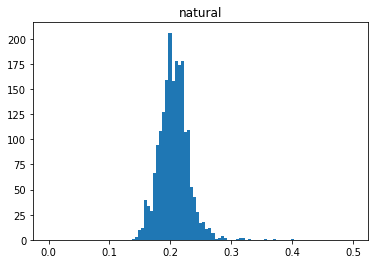

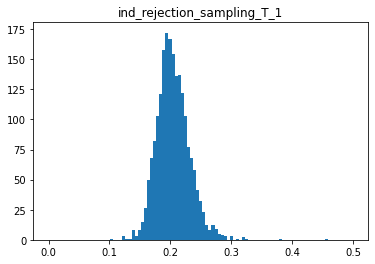

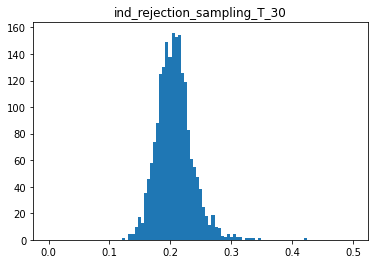

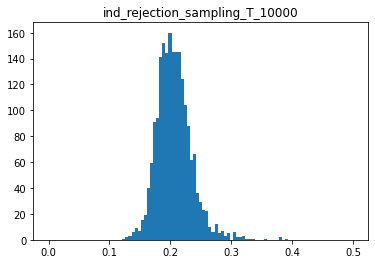

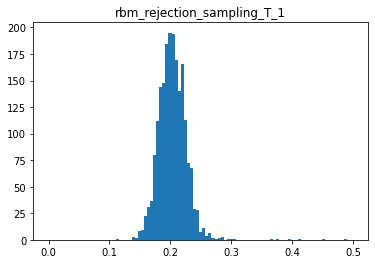

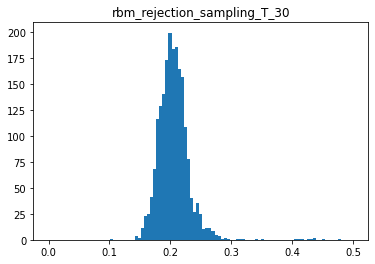

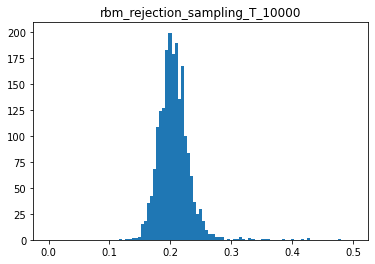

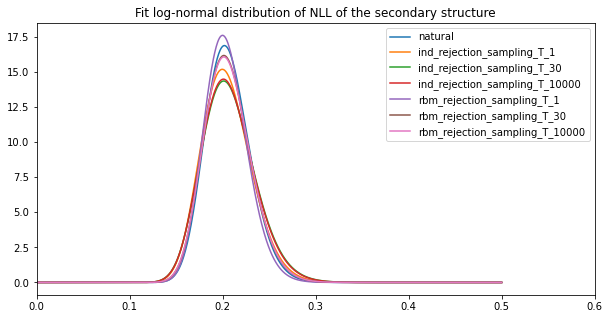

In [23]:
from scipy.stats import truncnorm, gamma, invgauss

m, M = 0, 0.5
x = np.linspace(m, M, 1000)
x_hist = np.linspace(m, M, 100)
pdfs = []
ssqa = []
for i, (m_,f) in enumerate(zip(matching,all_files)):
    m_ = m_.detach()
    mu, std = np.log(-np.array(m_)).mean(0), np.log(-np.array(m_)).std(0)
    pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * std**2)) / (x * std * np.sqrt(2 * np.pi)))
    pdfs.append(pdf)
    plt.hist(-np.array(m_), bins=x_hist)
    plt.title(f)
    plt.show()

plt.figure(figsize=(10,5))
for pdf in pdfs:
    plt.plot(x, pdf)

plt.xlim(0,0.6)
plt.legend(all_files)
plt.title("Fit log-normal distribution of NLL of the secondary structure")
plt.savefig('reports/img/sampling_ss.png')
plt.show()

In [16]:
p_ss3, ss_hmm, ls = matching[0]

ValueError: too many values to unpack (expected 3)

In [28]:
p_ss3.shape

torch.Size([2000, 3, 200])

In [25]:
np.exp(-0.2)

0.8187307530779818

In [45]:
x = torch.zeros(2000)
for i, l in enumerate(ls):
    x[i] = (ss_hmm[i,:,:l]*p_ss3[i,:,:l]).reshape(-1).sum(0)/l

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   1.,   1.,   0.,   1.,   1.,   4.,   0.,   1.,
          0.,   4.,   1.,   0.,   2.,   3.,   0.,   3.,   1.,   7.,   4.,
         14.,  15.,  39.,  55.,  78., 103., 143., 136., 138., 141., 178.,
        136., 132., 125., 116., 125., 112.,  74.,  23.,  17.,  16.,  11.,
          8.,   5.,   5.,   0.,   2.,   2.,   2.,   0.,   1.,   1.,   1.,
          0.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.42821026, 0.4291293 , 0.43004838, 0.43096742, 0.4318865 ,
        0.43280554, 0.4337246 , 0.43464366, 0.4355627 , 0.43648177,
        0.43740082, 0.4383199 , 0.43923894, 0.44015798, 0.44107705,
        0.4419961 , 0.44291517, 0.44383422, 0.4447533 , 0.44567233,
        0.44659138, 0.44751045, 0.4484295 , 0.

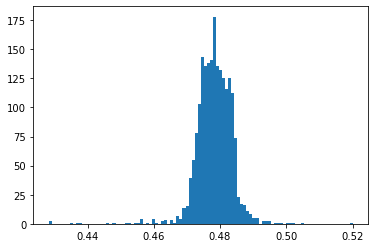

In [48]:
plt.hist(x.detach(), bins = 100)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

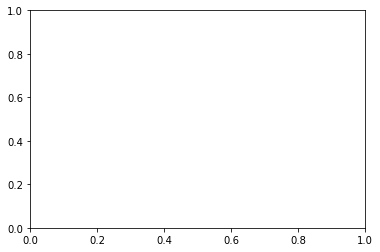

In [39]:
for i, (m_,f) in enumerate(zip(matching,all_files)):
    plt.hist(m_, bins = 100)
    plt.show()

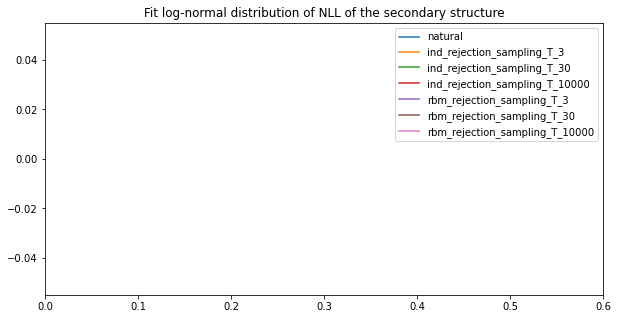

In [9]:
plt.figure(figsize=(10,5))
for pdf in pdfs:
    plt.plot(x, pdf)

plt.xlim(0,0.6)
plt.legend(all_files)
plt.title("Fit log-normal distribution of NLL of the secondary structure")
plt.savefig('reports/img/sampling_ss.png')
plt.show()

## Entropy

In [67]:
train_dataset = SequenceStructureData(f"{DATA}/{DATASET}", dataset="train")

fi = np.zeros((N, q))
for w, v in zip(train_dataset.weights,train_dataset.raw_sequences):
    fi += w*v
fi = torch.FloatTensor(fi).to(device)
fi /= fi.sum(-1).view(N,1)
p = fi.t().view(1,q,N)

In [68]:
def I_ind(x):
    return -(torch.log((p*x).sum(1)+1e-8)).sum(-1)/N

def I_DCA(x):
    d =  {"sequence":x}
    I = -(model1.integrate_likelihood(d, "hidden")/N - model1.Z)
    return I

def I_self(x):
    p = x.mean(0).view(1, *x.size()[1:])
    return -(torch.log((p*x).sum(1)+1e-8)).sum(-1)/N


In [69]:
x = torch.load(f"{DATA}/{DATASET}/gen_data/ind_rejection_sampling_T_30.pt")

In [70]:
Is = [I_ind(torch.load(f"{DATA}/{DATASET}/gen_data/{file}.pt")) for file in all_files]

In [71]:
Es = [I_DCA(torch.load(f"{DATA}/{DATASET}/gen_data/{file}.pt")) for file in all_files]

In [72]:
Hs = [I_self(torch.load(f"{DATA}/{DATASET}/gen_data/{file}.pt")) for file in all_files]

In [73]:
Ms = [-matcher(torch.load(f"{DATA}/{DATASET}/gen_data/{file}.pt")).detach() for file in all_files]

In [74]:
log21 = np.log(21)

In [75]:
print("| Generator | H(G\|N_ind) | H(G\|N_DCA) | H(G\|G_ind) | SS |")
print("|-----|-----|-----|-----|-----|")
for filename,i,e,h,m in zip(all_files,Is,Es,Hs,Ms):
    print(f"| {filename} | {i.mean().item()/log21:.2f} | {e.mean().item()/log21:.2f} | {h.mean().item()/log21:.2f} | {np.exp(-m).mean().item():.2f}")

| Generator | H(G\|N_ind) | H(G\|N_DCA) | H(G\|G_ind) | SS |
|-----|-----|-----|-----|-----|
| natural | 0.27 | 0.30 | 0.26 | 0.80
| rbm_seq | 0.28 | 0.33 | 0.28 | 0.78
| rbm_seq_ss | 0.27 | 0.32 | 0.27 | 0.80
| ind_rejection_sampling_T_3 | 0.27 | 0.41 | 0.27 | 0.79
| ind_rejection_sampling_T_10000 | 0.28 | 0.42 | 0.28 | 0.77
| rbm_rejection_sampling_T_3 | 0.28 | 0.33 | 0.27 | 0.80
| rbm_seq_ss_rejection_sampling_T_3 | 0.27 | 0.32 | 0.26 | 0.81


| Generator | H(G\|N_ind) | H(G\|N_DCA) | H(G\|G_ind) | SS |
|-----|-----|-----|-----|-----|
| natural | 0.27 | 0.31 | 0.26 | 0.80
| rbm_seq | 0.28 | 0.33 | 0.28 | 0.78
| rbm_seq_ss | 0.27 | 0.33 | 0.27 | 0.80
| ind_rejection_sampling_T_3 | 0.27 | 0.41 | 0.27 | 0.79
| ind_rejection_sampling_T_30 | 0.28 | 0.42 | 0.28 | 0.78
| ind_rejection_sampling_T_10000 | 0.28 | 0.42 | 0.28 | 0.77
| rbm_rejection_sampling_T_3 | 0.28 | 0.33 | 0.27 | 0.80
| meg_without_matching | 0.50 | 0.31 | 0.17 | 0.64
| meg_without_matching_better | 0.53 | 0.29 | 0.10 | 0.59
| meg_with_matching | 0.62 | 0.42 | 0.16 | 0.81
| meg_with_matching_better | 0.69 | 0.39 | 0.07 | 0.80

natural


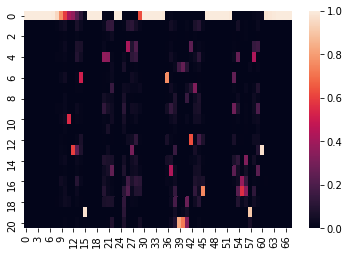

rbm_seq


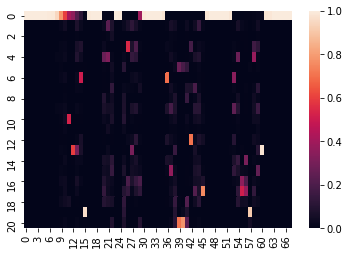

rbm_seq_ss


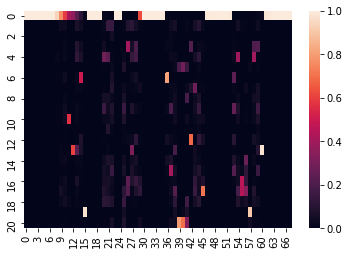

ind_rejection_sampling_T_3


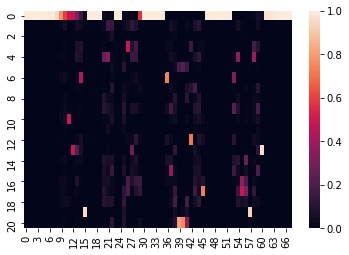

ind_rejection_sampling_T_30


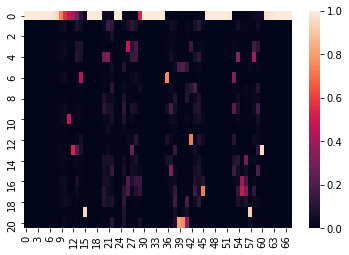

ind_rejection_sampling_T_10000


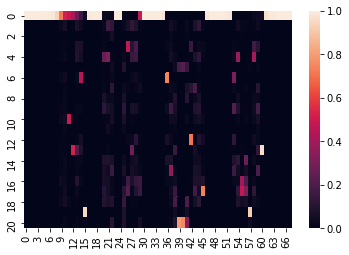

rbm_rejection_sampling_T_3


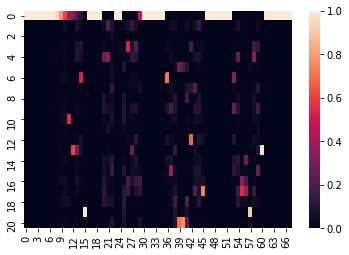

meg_without_matching


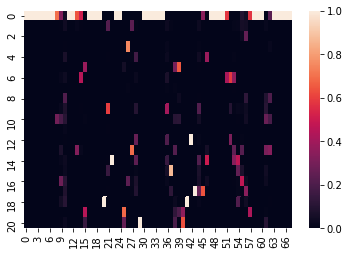

meg_with_matching


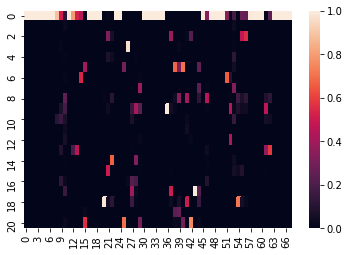

meg_without_matching_better


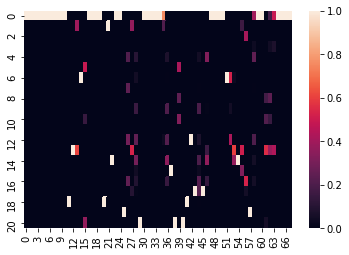

In [34]:
for filename in all_files:
    x = torch.load(f"{DATA}/{DATASET}/gen_data/{filename}.pt")
    print(filename)
    sns.heatmap(x.mean(0))
    plt.show()

## Modes

In [35]:
def KLD(p, q):
    if 0 in q:
        raise ValueError
    return sum(_p * np.log(_p/_q) for (_p, _q) in zip(p, q) if _p != 0)


class ModeCollapseEval(object):
    def __init__(self, classifier, n_stack, z_dim):
        self.classifier = Net().cuda()
        self.classifier.load_state_dict(torch.load('pretrained_classifier.pt'))
        self.n_stack = n_stack
        self.n_samples = 26 * 10 ** n_stack
        self.z_dim = z_dim

    def count_modes(self, netG):
        counts = np.zeros([10] * self.n_stack)
        n_batches = max(1, self.n_samples // 1000)
        for i in tqdm(range(n_batches)):
            with torch.no_grad():
                z = torch.randn(1000, self.z_dim).cuda()
                x_fake = netG(z) * .5 + .5
                x_fake = x_fake.view(-1, 1, 28, 28)
                classes = F.softmax(self.classifier(x_fake), -1).max(1)[1]
                classes = classes.view(1000, self.n_stack).cpu().numpy()

                for line in classes:
                    counts[tuple(line)] += 1

        n_modes = 10 ** self.n_stack
        true_data = np.ones(n_modes) / float(n_modes)
        num_modes_cap = len(np.where(counts > 0)[0])
        counts = counts.flatten() / counts.sum()
        kld = KLD(counts, true_data)
        print("No. of modes captured: ", num_modes_cap)
        print('Reverse KL: ', kld)
        return num_modes_cap, kld